## Project Name : Air Pressure Failure of Scania Trucks

## 1. Problem Definition 

The goal of the task, as presented by the Industrial Challenge for IDA 2016, wasto minimize maintenance costs of the air pressure system (APS) of Scania trucks.
Therefore, failures should be predicted before they occur. Falsely predicting a failure has a cost of 10, missing a failure a cost of 500. This leads to the need of
cost minimization.

## 2.Business Objectives and constraints

* No low-latency requirement.
* Errors can be costly.


## 3. ML Problem Formulation : Mapping problrm to the real world

### 3.1 Type of Machine learning problem

The problem is a binary classification problen where the classes represent the failure due to Pressure system or not

### 3.2 Performance metric and KPI

### Cost metric : 10* FP + 500* FN

## 4. Importing relevant libraries

In [1]:
import sklearn
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_recall_curve,auc,roc_auc_score,recall_score,classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from sklearn import svm
import random
from sklearn.model_selection import KFold
import pickle
from sklearn import metrics
from pandas import Series
from collections import defaultdict

# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Cross-Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Performance metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# For saving the model
import pickle

C:\Users\prash\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 5. Loading the dataset

In [2]:
data=pd.read_csv('ida_2016_training_set_update.csv')


In [3]:
data.shape

(60000, 171)

In [4]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
data_X = data.loc[:,data.columns != 'class']
data_Y = data.loc[:,data.columns == 'class']

### Since the classes here are pos and neg we will map them to 0 and 1

In [6]:
data_Y['class'] = data_Y['class'].map({'neg':0, 'pos':1})


/home/babita_chauhan0303/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### We can see that there are lot of na (missing values ) in our data . Hence we are converting numpy object so that we can easily impute them

In [7]:
data_X= data_X.replace(['na'],np.nan)





































































































































































































































































































































































































































































































































































































## 6. Train and Test split

In [8]:
## Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size = 0.27,random_state = 0)

In [9]:
print(X_train.shape)
Y_train=Y_train.values.ravel()
print(Y_train.shape)
print(X_test.shape)
Y_test=Y_test.values.ravel()
print(Y_test.shape)

(43799, 170)
(43799,)
(16201, 170)
(16201,)


## 7. Preprocessing and EDA

### Firstly we will try to remove columns and rows based on two heuristics 

### What we have observed is that there are lot of columns which have majority of the values as nan . Therefore its better to remove them and then perform imputation on remaining columns

In [10]:
#Define some function to handle data
#######################################################
def get_shape_and_col_labels(df):
    #Get the shape of the data
    num_rows,num_cols = df.shape
    #Get the col labels 
    data_cols = df.columns.values.tolist()
    
    return num_rows,num_cols,data_cols

In [11]:
#Eliminate some of the columns based on 2 heuristics

#Get the shape of the data
num_rows,num_cols,data_cols = get_shape_and_col_labels(X_train)

#Figure out the fraction of na values in the columns
num_nas = X_train.isnull().sum()
num_nas_vals = num_nas.values
num_nas_vals = num_nas_vals/num_rows
#print(num_nas_vals)

### HEURISTIC 1
### REMOVE Columns where the more than 10% of the entrys are 'na'

In [12]:
for col_index in range(num_cols):
    if num_nas_vals[col_index] > 0.1:
        x1=X_train.pop(data_cols[col_index])
        x2=X_test.pop(data_cols[col_index])

In [13]:
#Now that we have removed some of the columns
#Get the cols stuff again and the shape of the data
num_rows,num_cols,data_cols = get_shape_and_col_labels(X_train)


### HEURISTIC 2 
### Find rows where 90% of the entries are zero  even when the class is 'pos' .For each column find the fraction of entries that are zero

In [14]:
frac_zeros = {}
for col_label in data_cols:
    frac_zeros[col_label] = (X_train[col_label] == 0.0).sum()/num_rows
    
#For the Columns that are largely zeros, find the correlation 
#between the non zero values and having a positive result
#Remove the columns where it is zero
sum_corr = {}
for col_label in data_cols:
    if frac_zeros[col_label] > 0.9:
        sum_corr[col_label] = (X_train[col_label] * Y_train).sum()
        if sum_corr[col_label] == 0.0:
            x3=X_train.pop(col_label)
            x4=X_test.pop(col_label)

In [15]:
X_train.shape

(43799, 142)

In [16]:
X_test.shape

(16201, 142)

## Imputation 

## Replacing the missing values with KNN Fancy impute

### Standardizing the train and test set

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

### I tried to compute KNN based imputation on my machine but it raised memory error and since i wasnt getting reduced good costs values with other imputation techniques i directly loaded knn imputation  results 

In [2]:
data=pd.read_csv("aps_failure_training_set_processed_8bit.csv")

In [3]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


In [4]:
data["class"][data["class"] > 0] = 1
data["class"][data["class"] < 0] = 0

In [5]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,0.0,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,0.0,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,0.0,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,0.0,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


In [6]:
data.shape

(60000, 171)

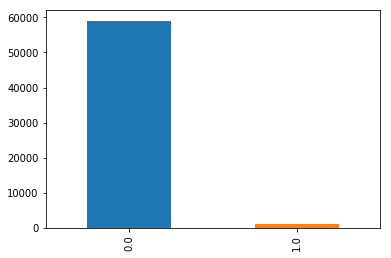

In [7]:
data['class'].value_counts().plot(kind='bar')

In [8]:
data_X = data.loc[:,data.columns != 'class']
data_Y = data.loc[:,data.columns == 'class']

In [9]:
data_X.shape

(60000, 170)

In [10]:
data_Y=data_Y.values.ravel()
data_Y.shape

(60000,)

## 8. Train-Test Split

In [11]:
## Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size = 0.27,random_state = 0)

## 9. Machine Learning Models

In [299]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(43799, 170)
(43799,)
(16201, 170)
(16201,)


In [13]:
def evaluate(y_test,y_pred,y_pred_proba):
    if len(y_pred)>0:
        f1 = f1_score(y_test,y_pred,average="weighted")
        print("F1 score: ",f1)
    if len(y_pred_proba)>0:
        logloss = log_loss(y_test,y_pred_proba, eps=1e-15, normalize=True, sample_weight=None, labels=None)
        print("Log loss for predicted probabilities:",logloss)

## 9.1 Logistic regression

In [72]:
## Classifier=Logistic Regression
## Defining function to find optimal value of hyperparameter with Grid Search CV
from sklearn.calibration import CalibratedClassifierCV

def hyparameter_Log_gscv(X_train,Y_train):
    clf=LogisticRegression(class_weight='balanced')
    #sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    # predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    #cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    #print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    ## Parameters we need to try on classifier
    param_grid={'C' : [0.001,0.01,0.1,0.5,1,5,10,25,50,100],'penalty':['l1','l2']}
    gsv=GridSearchCV(clf,param_grid,cv=3,verbose=1,scoring='roc_auc')
    gsv.fit(X_train,Y_train)
    optimal_C=gsv.best_params_.get('C')
    optimal_penalty=gsv.best_params_.get('penalty')
    accuracy=gsv.best_score_
    print("The optimal_value of C and penalty for Logistic Regression with GridSearchCV is : ",gsv.best_params_)
    print("The accuracy corresponing to optimal_C annd optimal_penalty is : ", np.round((accuracy)*100,4))
    
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for item in gsv.grid_scores_:
        if(item[0]['penalty'])=='l1':
            y1.append(1-item[1])
            x1.append(item[0]['C'])
        else:
            y2.append(1-item[1])
            x2.append(item[0]['C'])
    plt.xlim(-0.001,100)
    plt.ylim(0,0.5)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Missclassification Error")
    plt.title("Missclassification Error Vs C")
    plt.plot(x1,y1,'b',label="l1")
    plt.plot(x2,y2,'r',label="l2")
    plt.legend()
    plt.show


    return optimal_C
    return optimal_penalty
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 39.7min finished


The optimal_value of C and penalty for Logistic Regression with GridSearchCV is :  {'C': 0.1, 'penalty': 'l2'}
The accuracy corresponing to optimal_C annd optimal_penalty is :  98.7805


C:\Users\prash\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.1

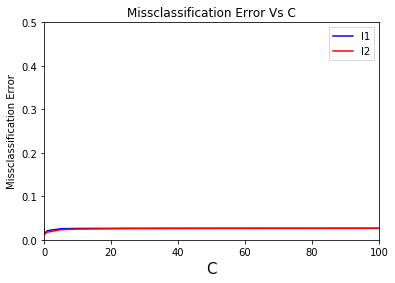

In [73]:
hyparameter_Log_gscv(X_train,Y_train)

In [38]:
classifier=LogisticRegression(penalty='l2',C=0.1,class_weight='balanced')
# Fitting X_train and Y_train to the claswsifier
classifier.fit(X_train,Y_train)
# Predict on X_test
Y_pred =classifier.predict(X_test)
Y_pred_proba=classifier.predict_proba(X_test)
evaluate(Y_test,Y_pred,Y_pred_proba)

F1 score:  0.9736386234553713
Log loss for predicted probabilities: 0.10590475830352539


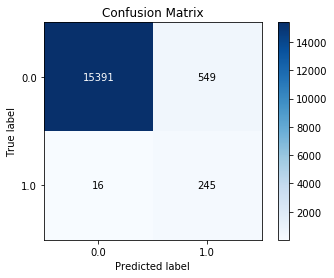

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     15940
        1.0       0.31      0.94      0.46       261

avg / total       0.99      0.97      0.97     16201



In [39]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [40]:
total_cost = 10*fp + 500*fn
print(total_cost)

13490


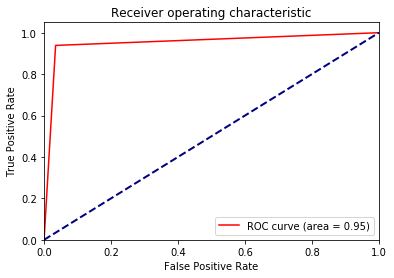

In [41]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Until now, our model has been making label predictions. The threshold used for making these predictions in 0.5 
Credits:https://www.analyticsvidhya.com/blog/2016/09/this-machine-learning-project-on-imbalanced-data-can-add-value-to-your-resume/

Due to imbalanced nature of the data, the threshold of 0.5 will always favor the majority class since the probability of a class 1 is quite low. Now, we’ll try a new technique:

Instead of labels, we’ll predict probabilities
Plot and study the AUC curve
Adjust the threshold for better prediction

### From the ROC CURVE we can see that my TP almost remain constant with change in thrsholds beyond approximately 0.05 .Since my overall objective is to prevent FP i can adjust the thresholds

In [63]:
Y_test_predictions_prec = Y_pred_proba[:,1] > 0.28

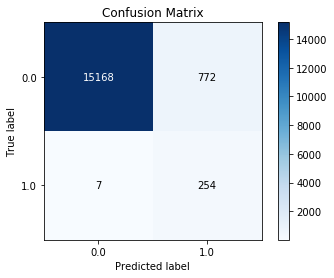

             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97     15940
        1.0       0.25      0.97      0.39       261

avg / total       0.99      0.95      0.97     16201



In [64]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_test_predictions_prec).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_predictions_prec, normalize=False)
plt.show()
print(classification_report(Y_test,Y_test_predictions_prec))

In [65]:
total_cost = 10*fp + 500*fn
print(total_cost)

11220


## Linear SVC

In [86]:
from sklearn.svm import LinearSVC

classifier=LinearSVC(penalty='l2',C=0.001,class_weight='balanced',tol=1e-5)

# Fitting X_train and Y_train to the claswsifier
classifier.fit(X_train,Y_train)
# Predict on X_test
Y_pred =classifier.predict(X_test)
#Y_pred_proba=classifier.predict_proba(X_test)
#evaluate(Y_test,Y_pred,Y_pred_proba)

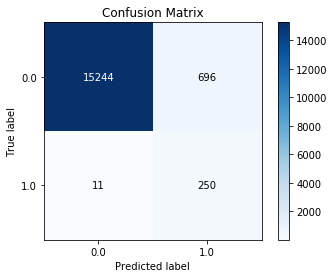

             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     15940
        1.0       0.26      0.96      0.41       261

avg / total       0.99      0.96      0.97     16201



In [87]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [88]:
total_cost = 10*fp + 500*fn
print(total_cost)

12460


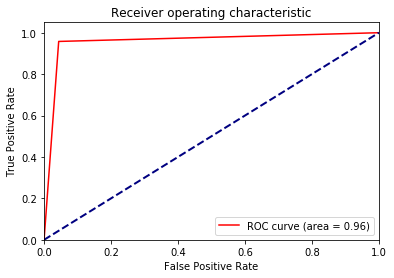

In [89]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes 

In [91]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,Y_train)

Y_pred =classifier.predict(X_test)
Y_pred_proba=classifier.predict_proba(X_test)
evaluate(Y_test,Y_pred,Y_pred_proba)

F1 score:  0.9436571891077821
Log loss for predicted probabilities: 2.7945076022198023


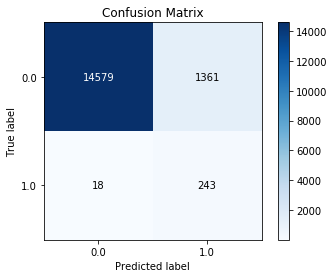

             precision    recall  f1-score   support

        0.0       1.00      0.91      0.95     15940
        1.0       0.15      0.93      0.26       261

avg / total       0.99      0.91      0.94     16201



In [92]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [93]:
total_cost = 10*fp + 500*fn
print(total_cost)

22610


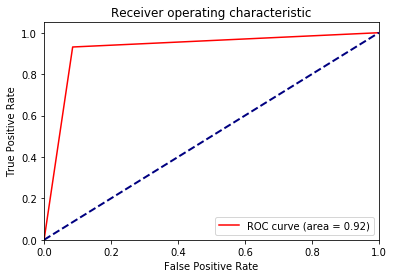

In [94]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [101]:
Y_test_predictions_prec = Y_pred_proba[:,1] > 0.1

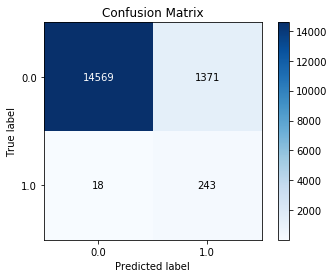

             precision    recall  f1-score   support

        0.0       1.00      0.91      0.95     15940
        1.0       0.15      0.93      0.26       261

avg / total       0.99      0.91      0.94     16201



In [102]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_test_predictions_prec).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_predictions_prec, normalize=False)
plt.show()
print(classification_report(Y_test,Y_test_predictions_prec))

In [103]:
total_cost = 10*fp + 500*fn
print(total_cost)

22710


## 9.3) Random Forest 

In [97]:
## Classifier: Random Forest Classifier
## Defining function to find optimal value of hyperparameter with Grid Search CV

def hyperparameter_RF_gscv(X_train,Y_train):
        
        classifier=RandomForestClassifier(class_weight='balanced')
        param_grid = {'n_estimators':[x for x in range(1,500,50)]} #params we need to try on classifier
        gsv = GridSearchCV(classifier,param_grid,cv=3,verbose=1,scoring='roc_auc')
        gsv.fit(X_train,Y_train)
        X_gsv=[]
        Y_gsv=[]
        for item in gsv.grid_scores_:
            X_gsv.append(item[0]['n_estimators'])
            Y_gsv.append(item[1])
        optimal_n_estimators=gsv.best_params_.get('n_estimators')
        return optimal_n_estimators

In [98]:
hyperparameter_RF_gscv(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.2min finished
C:\Users\prash\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


301

In [14]:
forest_clf = RandomForestClassifier(n_estimators=301)
forest_clf.fit(X_train,Y_train)
Y_pred = forest_clf.predict(X_test)
Y_pred_proba = forest_clf.predict_proba(X_test)
evaluate(Y_test,Y_pred,Y_pred_proba)

F1 score:  0.9916324090167133
Log loss for predicted probabilities: 0.025354423305683903


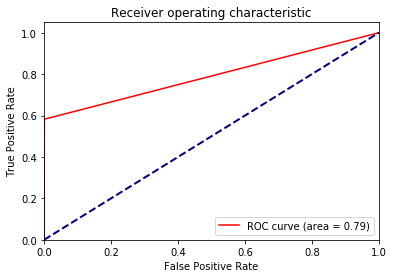

In [21]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### WE can see that in this case the ROC curve is increasing linearly. So in this case if i try to adjust thrsholds my TP will be effected 

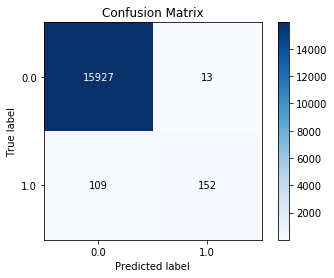

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     15940
        1.0       0.92      0.58      0.71       261

avg / total       0.99      0.99      0.99     16201



In [22]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [23]:
total_cost = 10*fp + 500*fn
print(total_cost)

54630


## 9.4 GBDT

In [142]:
## Classifier: GBDT(XGBOOST)
## Defining function to find optimal value of hyperparameter with Grid Search CV
from xgboost import XGBClassifier

def hyperparameter_GBDT_gscv(X_train,Y_train):
        
        classifier1=XGBClassifier(class_weight='balanced')
        param_grid = {'n_estimators':[x for x in range(1,300,50)],'max_depth':[x for x in range (1,20,2)],'learning_rate':[0.1,0.2,0.4,1.0]} 
        gsv = GridSearchCV(classifier1,param_grid,cv=3,verbose=1,scoring='roc_auc')
        gsv.fit(X_train,Y_train)
        X_gsv=[]
        Y_gsv=[]
        optimal_depth=gsv.best_params_.get('max_depth')
        optimal_n_estimators=gsv.best_params_.get('n_estimators')
        optimal_learning_rate=gsv.best_params_.get('learning_rate')
        print("Best HyperParameter: ",gsv.best_params_)
        print("Best f1-score: %.2f%%"%(gsv.best_score_*100))
        return optimal_depth,optimal_n_estimators,optimal_learning_rate
        

In [156]:
hyperparameter_GBDT_gscv(X_train,Y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 696.4min finished


Best HyperParameter:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 101}
Best f1-score: 98.93%


(5, 101, 0.2)

In [289]:
clf =XGBClassifier(class_weight='balanced',n_estimators=101,max_depth=5,learning_rate=0.2)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
Y_pred_proba = clf.predict_proba(X_test)
evaluate(Y_test,Y_pred,Y_pred_proba)

C:\Users\prash\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score:  0.9933566109896081
Log loss for predicted probabilities: 0.021915212980952416


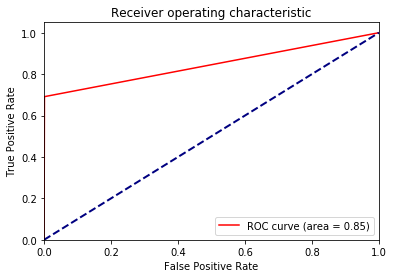

In [295]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

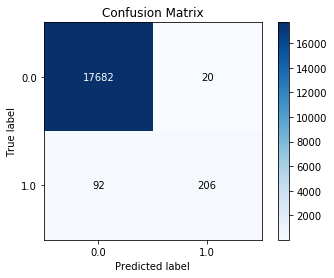

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     17702
        1.0       0.91      0.69      0.79       298

avg / total       0.99      0.99      0.99     18000



In [296]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [297]:
total_cost = 10*fp + 500*fn
print(total_cost)

46200


In [291]:
total_cost = 10*fp + 500*fn
print(total_cost)

46200


In [274]:
Y_test_predictions = Y_pred_proba[:,1] > 0.1
Y_test_predictions_prec = Y_pred_proba[:,1] > 0.26

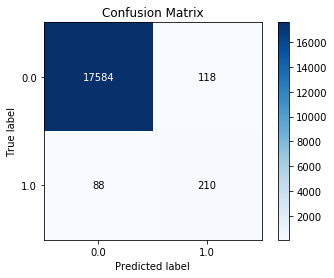

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     17702
        1.0       0.64      0.70      0.67       298

avg / total       0.99      0.99      0.99     18000



In [275]:
tn, fp, fn, tp = confusion_matrix(Y_test,Y_test_predictions_prec ).ravel()
skplt.metrics.plot_confusion_matrix(Y_test,Y_test_predictions_prec, normalize=False)
plt.show()
print(classification_report(Y_test,Y_test_predictions_prec))

In [276]:
total_cost = 10*fp + 500*fn
print(total_cost)

45180


## 9.4 Catboost

In [315]:
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor


In [323]:
categorical_features_indices=np.where(data_X.dtypes != np.float)[0]


In [355]:
model = CatBoostClassifier(
    iterations=1000,
    random_seed=38,
    learning_rate=0.2,
    loss_function= 'Logloss',
    eval_metric="AUC",
    use_best_model=True
    
)

model.fit(
    X_train, Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_proba = model.predict_proba(X_test)
evaluate(Y_test,Y_pred,Y_pred_proba)

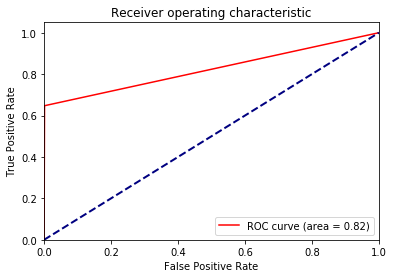

In [350]:
#display ROC curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

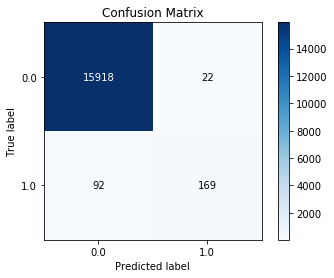

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     15940
        1.0       0.88      0.65      0.75       261

avg / total       0.99      0.99      0.99     16201



In [351]:
import scikitplot as skplt
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, normalize=False)
plt.show()
print(classification_report(Y_test,Y_pred))

In [352]:
total_cost = 10*fp + 500*fn
print(total_cost)

46220


## Summary 

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Classifier","Threshold" ,"Score"]

x.add_row(["LogisticRegression",0.5,13490])
x.add_row(["LogisticRegression",0.28,11220])
x.add_row(["LinearSVC",0.5,12460])
x.add_row(["Random Forest",0.5,54630])
x.add_row(["GBDT",0.5,46200])
x.add_row(["GBDT",0.26,45180])
x.add_row(["Catboost",0.5,46220])



print(x)

+--------------------+-----------+-------+
|     Classifier     | Threshold | Score |
+--------------------+-----------+-------+
| LogisticRegression |    0.5    | 13490 |
| LogisticRegression |    0.28   | 11220 |
|     LinearSVC      |    0.5    | 12460 |
|   Random Forest    |    0.5    | 54630 |
|        GBDT        |    0.5    | 46200 |
|        GBDT        |    0.26   | 45180 |
|      Catboost      |    0.5    | 46220 |
+--------------------+-----------+-------+


## The best score obtained is 11220.